In [ ]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gamma, dirichlet,norm
from scipy import special
import copy

In [ ]:
# Initialize Prior:
# prior is Ditchlet Normal Gamma, Initilaize the parameters for it.
num_classes = 5
# dirchlet
a = np.random.randint(0,10,num_classes)+1
print(a)
print(np.random.dirichlet(a))
# Generation of random variates is straightforward:

    # Sample τ \tau from a gamma distribution with parameters α \alpha and β \beta
    # Sample x x from a normal distribution with mean μ \mu and variance 1 / ( λ τ ) 1/(\lambda \tau )
# normal-gamma

# comparing with paper = wikipedia, kappa= lamda, alphas = mu0 , beta = alphas, gamma = beta
alphas = np.random.rand(num_classes) +1
kappas = np.ones(num_classes)
betas = 5*np.ones(num_classes)
gammas = np.ones(num_classes)
a = np.random.randint(0,10,num_classes)+1
# prior of parameters initialized

class Parameters:
  def __init__(self, a,alphas, kappas, betas, gammas):
    assert a.shape[0] == alphas.shape[0]
    assert kappas.shape[0] == betas.shape[0]
    assert gammas.shape[0] == betas.shape[0]
    assert gammas.shape[0] == a.shape[0]
    self.a = a
    self.alphas = alphas
    self.kappas = kappas
    self.betas = betas
    self.gammas = gammas

  def print_param(self, msg):
    print(self.a ,msg,"a")
    print(self.alphas ,msg,"alphas")
    print(self.kappas ,msg,"kappas")
    print(self.betas ,msg,"betas")
    print(self.gammas ,msg,"gammas")

prior_params = Parameters(a,alphas, kappas, betas, gammas)

[10  8  6  3  9]
[0.17852586 0.2912863  0.12991925 0.09345286 0.30681572]


In [ ]:
# calculate required pdfs
def prior_pdf(weights, means, lambdas, Parameters):

  assert np.sum(weights, axis=0).all()==1
  dir = dirichlet.pdf(weights, Parameters.a)
  gam = gamma.pdf(lambdas, a = Parameters.betas,loc = 0,scale = 1/Parameters.gammas)
  normal = norm.pdf(x=means, loc=Parameters.alphas, scale= np.sqrt(1/np.multiply(Parameters.kappas,lambdas)))

  return dir*np.prod(np.multiply(gam,normal))

def posterior_pdf_singleterm(weights, means, lambdas,c, Parameters):
  assert np.sum(weights,axis=0).all()==1
  return c*prior_pdf(weights, means, lambdas, Parameters)


def swap_element_in_params(i,temp_params,post_params):
  temp_params.a[i] = copy.deepcopy(post_params.a[i])
  temp_params.alphas[i] = copy.deepcopy(post_params.alphas[i])
  temp_params.kappas[i] = copy.deepcopy(post_params.kappas[i])
  temp_params.betas[i] = copy.deepcopy(post_params.betas[i])
  temp_params.gammas[i] = copy.deepcopy(post_params.gammas[i])
  return temp_params


def full_posterior_pdf(weights, means, lambdas,c_array,prior_params, post_params):
  pdf_array = np.zeros(weights.shape[0])
  for i in range(weights.shape[0]):
    temp_params = copy.deepcopy(prior_params)
    temp_params = swap_element_in_params(i,temp_params,post_params)
    pdf_array[i] = posterior_pdf_singleterm(weights, means, lambdas,c_array[i], temp_params)

  return np.sum(pdf_array)

def update_params(meas,prior_params):
  post_params = copy.deepcopy(prior_params)
  post_params.alphas = np.divide((np.multiply(prior_params.kappas,prior_params.alphas) +meas) , prior_params.kappas+1)
  post_params.kappas = prior_params.kappas+1
  post_params.betas = prior_params.betas +0.5
  post_params.gammas=prior_params.gammas + prior_params.kappas  *  (np.square(prior_params.alphas-meas)/ (2*(prior_params.kappas+1)))
  c_array = np.zeros(prior_params.kappas.shape[0])
  c_array = np.sqrt(prior_params.kappas/post_params.kappas) * (special.gamma(post_params.betas)/special.gamma(prior_params.betas)) * ((prior_params.gammas**prior_params.betas)/(post_params.gammas**post_params.betas))
  post_params.a = prior_params.a +1

  return post_params, c_array # the normalization is not from paper

In [ ]:
print(special.gamma(np.array([23.7,1.6])))

[1.00461418e+22 8.93515349e-01]


In [ ]:
# test functions,

weights = np.random.randint(0,10,num_classes)
weights = weights/np.sum(weights)
means = 1+ + np.random.rand(num_classes)
lambdas = 1/(3*np.random.rand(num_classes)+1)
# c_array = np.ones(num_classes)

prior_params = Parameters(a,alphas, kappas, betas, gammas)
meas = 2
post_params, c_array = update_params(meas,prior_params)

print(c_array)
print(np.sqrt(prior_params.kappas/post_params.kappas) * (special.gamma(post_params.betas)/special.gamma(prior_params.betas)))
# print(prior_pdf(weights, means, lambdas,prior_params))
print(full_posterior_pdf(weights, means, lambdas,c_array,prior_params, post_params))
print(np.sqrt(prior_params.kappas/post_params.kappas) * (special.gamma(post_params.betas)/special.gamma(prior_params.betas)) * ((prior_params.gammas**prior_params.betas)/(post_params.gammas**post_params.betas)))

[1.25016885 0.71134535 1.26163357 1.20017059 0.50024194]
[1.54216388 1.54216388 1.54216388 1.54216388 1.54216388]
8.676135471982264e-20
[1.25016885 0.71134535 1.26163357 1.20017059 0.50024194]


In [ ]:
# Generate measurements

def gen_measurements(num_meas, weights,means,lambdas):
  random_pool = np.random.choice(range(weights.shape[0]), size=num_meas, p = weights)
  pool_array,trash = np.histogram(random_pool , bins=weights.shape[0], range = (0,weights.shape[0]-1))
  meas = np.zeros(num_meas)

  for i in range(pool_array.shape[0]):
    meas[np.nansum(pool_array[:i]): np.nansum(pool_array[:i+1])] = (1/(np.sqrt(lambdas[i])))*np.random.randn(pool_array[i]) + means[i]
  return meas

# sample full pdf :

def samples_normal_gamms(params,num_gauss_samples):
  mean_tau_samples = np.zeros((params.alphas.shape[0],num_gauss_samples, 2))
  for i in range(params.alphas.shape[0]):
    tau_samples = np.random.gamma(params.betas[i], 1/params.gammas[i] , num_gauss_samples)
    mean_samples = (1/np.sqrt(params.kappas[i]*tau_samples))*np.random.randn(num_gauss_samples) + params.alphas[i]
    mean_tau_samples[i,:,0] = mean_samples
    mean_tau_samples[i,:,1] = tau_samples

  return mean_tau_samples

def samples_dirchilet(params, num_dir_samples):

  return np.random.dirichlet(params.a, num_dir_samples).T\


# def sample_normal_gamma(params,num_gauss_samples):
#   mean_samples = np.zeros((params.alphas.shape[0],num_gauss_samples))
#   for i in range(params.alphas.shape[0]):
#     tau_samples = np.random.gamma(params.betas[i], 1/params.gammas[i] , num_gauss_samples)
#     mean_samples = (1/np.sqrt(params.kappas[i]*tau_samples))*np.random.randn(num_gauss_samples) + params.alphas[i]
#     mean_tau_samples[i,:,0] = mean_samples
#     mean_tau_samples[i,:,1] = tau_samples

# def sample_fullPostPdf(prior_params,post_params, c_array,num_samples):

#   dir_mean_tau_samples_combi = np.zeros(( prior_params.alphas.shape[0],num_samples, 3))

#   random_pool = np.random.choice(range(c_array.shape[0]), size=num_samples, p = c_array/np.sum(c_array))
#   pool_array,trash = np.histogram(random_pool , bins=c_array.shape[0], range = (0,c_array.shape[0]-1))
#   print(pool_array)

#   for i in range(pool_array.shape[0]):

#     temp_params = copy.deepcopy(prior_params)
#     temp_params = swap_element_in_params(i,temp_params,post_params)
#     dir_mean_tau_samples_combi[:,np.nansum(pool_array[:i]): np.nansum(pool_array[:i+1]),0] =  samples_dirchilet(temp_params, pool_array[i])
#     dir_mean_tau_samples_combi[:,np.nansum(pool_array[:i]): np.nansum(pool_array[:i+1]),1:] =  samples_normal_gamms(temp_params, pool_array[i])

#   return dir_mean_tau_samples_combi

# def sample_fullPostPdf(prior_params,post_params, c_array,num_samples):
#   dir_mean_tau_samples_full = np.zeros((c_array.shape[0], prior_params.alphas.shape[0],num_samples, 3))

#   for i in range(c_array.shape[0]):

#     temp_params = copy.deepcopy(prior_params)
#     temp_params = swap_element_in_params(i,temp_params,post_params)
#     dir_mean_tau_samples_full[i,:,:,0] =  samples_dirchilet(temp_params, num_samples)
#     dir_mean_tau_samples_full[i,:,:,1:] = samples_normal_gamms(temp_params, num_samples)

#   return dir_mean_tau_samples_full


# def sample_fullPostPdf(prior_params,post_params, c_array,num_samples):
#   dir_mean_tau_samples_full = np.zeros((c_array.shape[0], prior_params.alphas.shape[0],num_samples, 3))

#   for i in range(c_array.shape[0]):

#     temp_params = copy.deepcopy(prior_params)
#     temp_params = swap_element_in_params(i,temp_params,post_params)
#     dir_mean_tau_samples_full[i,:,:,0] =  c_array[i]*samples_dirchilet(temp_params, num_samples)
#     dir_mean_tau_samples_full[i,:,:,1:] = c_array[i]*samples_normal_gamms(temp_params, num_samples)

#   return np.sum(dir_mean_tau_samples_full, axis = 0)

def sample_fullPostPdf(prior_params,post_params, c_array,num_samples):
  dir_mean_tau_samples_full = np.zeros((c_array.shape[0], prior_params.alphas.shape[0],num_samples, 3))

  for i in range(c_array.shape[0]):

    temp_params = copy.deepcopy(prior_params)
    temp_params = swap_element_in_params(i,temp_params,post_params)
    dir_mean_tau_samples_full[i,:,:,0] =  samples_dirchilet(temp_params, num_samples)
    dir_mean_tau_samples_full[i,:,:,1:] = samples_normal_gamms(temp_params, num_samples)

  return dir_mean_tau_samples_full

In [ ]:
# num_samples= 200000
# c_array = np.array([0.1,0.1,0.2,0.2,0.4])
# dir_mean_tau_samples_combi= sample_fullPostPdf(prior_params,post_params,c_array,num_samples)
# # print(samples_dirchilet(prior_params, 100))
# print(np.sum(samples_dirchilet(prior_params, 100), axis=0))
# print(np.sum(dir_mean_tau_samples_combi[:,36,0]))
# print(full_posterior_pdf(dir_mean_tau_samples_combi[:,0,0], dir_mean_tau_samples_combi[:,0,1], dir_mean_tau_samples_combi[:,0,2],c_array,prior_params, post_params))

In [ ]:

# c_array = np.array([0.1,0.2,0.1,0.3, 0.3])
# print(np.nansum(c_array[:0]))
# k =np.random.choice(range(c_array.shape[0]), size=10, p = c_array)
# print(k)
# l ,p = np.histogram(k , bins=5, range = (0,4))
# print(l)
# num_samples = 100

# # print(np.histogram(k, bins= c_array.shape[0]))

In [ ]:

# def evaluateMoments(prior_params,post_params, c_array,num_samples= 200000):

#   dir_mean_tau_samples_combi= sample_fullPostPdf(prior_params,post_params,c_array,num_samples)
# #   pdf_evals_array = np.zeros(num_samples)

# # # idiot you dont need this for MC approximation
# #   for i in range(num_samples):
# #     pdf_evals_array[i] = full_posterior_pdf(dir_mean_tau_samples_combi[:,i,0], dir_mean_tau_samples_combi[:,i,1], dir_mean_tau_samples_combi[:,i,2],c_array,prior_params, post_params)
# #   print(np.sum(pdf_evals_array))

#   # E[mu]
#   alphas_up = np.zeros(prior_params.alphas.shape[0])
#   alphas_up = np.mean(dir_mean_tau_samples_combi[:,:,1],axis=1 )

#   # for i in range(prior_params.alphas.shape[0]):
#   #   gfunc = dir_mean_tau_samples_combi[i,:,1]
#   #   alphas_up[i] = np.mean(gfunc)
#   # print(alphas_up, "mus")

#     # kappa up
#   kappa_up = np.zeros(prior_params.alphas.shape[0])
#   exp_lamda = np.zeros(prior_params.alphas.shape[0])
#   exp_mu_lamda_sq = np.zeros(prior_params.alphas.shape[0])

#   exp_lamda = np.mean(dir_mean_tau_samples_combi[:,:,2], axis=1)
#   exp_mu_lamda_sq = np.mean(dir_mean_tau_samples_combi[:,:,1]*np.square(dir_mean_tau_samples_combi[:,:,2]), axis=1)
#   kappa_up = 1/(exp_mu_lamda_sq- (alphas_up**2)*exp_lamda)



#   # for i in range(prior_params.alphas.shape[0]):
#   #   exp_mu_lamda_sq = np.mean(dir_mean_tau_samples_combi[i,:,1]*np.square(dir_mean_tau_samples_combi[i,:,2]))



#     # kappa_up[i] = 1/(exp_mu_lamda_sq- (alphas_up[i]**2)*exp_lamda[i])
#   print(kappa_up, "kappa_up")


#     # beta_up
#   beta_up = np.zeros(prior_params.alphas.shape[0])
#   exp_lamda_sq = np.zeros(prior_params.alphas.shape[0])
#   exp_lamda_sq = np.mean(np.square(dir_mean_tau_samples_combi[:,:,2]), axis = 1)
#   beta_up = (exp_lamda**2)/(exp_lamda_sq- (exp_lamda**2))

#   # for i in range(prior_params.alphas.shape[0]):
#   #   exp_lamda_sq[i] = np.mean(np.square(dir_mean_tau_samples_combi[i,:,2]))
#   #   beta_up[i] = (exp_lamda[i]**2)/(exp_lamda_sq[i]- (exp_lamda[i]**2))

#   # gamma_up
#   gamma_up = np.zeros(prior_params.alphas.shape[0])
#   gamma_up = (exp_lamda)/(exp_lamda_sq- (exp_lamda**2))

#   # for i in range(prior_params.alphas.shape[0]):
#   #   gamma_up[i] = (exp_lamda[i])/(exp_lamda_sq[i]- (exp_lamda[i]**2))

#   # a_up
#   a_up = np.zeros(prior_params.alphas.shape[0])
#   exp_weigh = np.zeros(prior_params.alphas.shape[0])

#   exp_weigh = np.mean(dir_mean_tau_samples_combi[:,:,0], axis =1)
#   exp_weigh_sq = np.mean(np.square(dir_mean_tau_samples_combi[:,:,0]), axis = 1)
#   a_up = (exp_weigh)*((exp_weigh- exp_weigh_sq)/(exp_weigh_sq - exp_weigh**2))



#   # for i in range(prior_params.alphas.shape[0]):
#   #   exp_weigh[i] = np.mean(dir_mean_tau_samples_combi[i,:,0])
#   #   exp_weigh_sq = np.mean(np.square(dir_mean_tau_samples_combi[i,:,0]))
#   #   a_up[i] = (exp_weigh[i])*((exp_weigh[i]- exp_weigh_sq)/(exp_weigh_sq - exp_weigh[i]**2))
#   # # a_up = post_params.a
#   print(exp_weigh,"ex[W")

#   # print(exp_weigh,"weights")

#   # after moment matching
#   next_params = copy.deepcopy(prior_params)
#   next_params.a = a_up
#   print(a_up, "param a")
#   print(next_params.a, "param a")
#   next_params.alphas = alphas_up
#   print(alphas_up, "param alphas_up")
#   next_params.kappas = kappa_up
#   print(kappa_up, "param kappa_up")
#   print(kappa_up, "param kappa_up")
#   next_params.betas = beta_up
#   print(beta_up, "param beta_up")
#   print(beta_up, "param beta_up")
#   next_params.gammas = gamma_up
#   print(gamma_up, "param gamma_up")
#   print(gamma_up, "param gamma_up")
#   return next_params


#  okay i thinkl i am doing something wrong, revaluate how you sample a pdf with summations inside of it;




In [ ]:
b = np.array([[1,2,3],[3,4,5]])
print(np.mean(b, axis=1))

[2. 4.]


In [ ]:

def evaluateMoments(prior_params,post_params, c_array,num_samples= 200000):

  dir_mean_tau_samples_full= sample_fullPostPdf(prior_params,post_params,c_array,num_samples)
  print(dir_mean_tau_samples_full.shape)

  # E[mu]
  alphas_up = np.zeros(prior_params.alphas.shape[0])
  gfunc_mu_full = np.zeros((c_array.shape[0],prior_params.alphas.shape[0], num_samples ))
  for i in range(prior_params.alphas.shape[0]):
    gfunc_mu_full[i,:,:] = c_array[i]*dir_mean_tau_samples_full[i,:,:,1]

  gfunc_mu_actual = np.sum(gfunc_mu_full, axis=0)
  print(gfunc_mu_actual.shape)
  alphas_up = np.mean(gfunc_mu_actual, axis =1)
  print(alphas_up, "alphas")


    # kappa up
  kappa_up = np.zeros(prior_params.alphas.shape[0])
  gfunc_mu_lamda_sq_full = np.zeros((c_array.shape[0],prior_params.alphas.shape[0], num_samples ))
  gfunc_lamda_full = np.zeros((c_array.shape[0],prior_params.alphas.shape[0], num_samples ))
  exp_mu_lamda_sq = np.zeros(prior_params.alphas.shape[0])
  exp_lamda = np.zeros(prior_params.alphas.shape[0])

  for i in range(prior_params.alphas.shape[0]):
    gfunc_mu_lamda_sq_full[:,i,:] = dir_mean_tau_samples_full[:,i,:,1]*np.square(dir_mean_tau_samples_full[:,i,:,2])

  for i in range(c_array.shape[0]):
    gfunc_mu_lamda_sq_full[i,:,:] = c_array[i]*gfunc_mu_lamda_sq_full[i,:,:]
    gfunc_lamda_full[i,:,:] = c_array[i]*dir_mean_tau_samples_full[i,:,:,2]


  gfunc_mu_lamda_sq_actual = np.sum(gfunc_mu_lamda_sq_full, axis=0)
  gfunc_lamda_actual = np.sum(gfunc_lamda_full, axis=0)

  exp_mu_lamda_sq = np.mean(gfunc_mu_lamda_sq_actual, axis =1)
  exp_lamda = np.mean(gfunc_lamda_actual, axis =1)


  kappa_up =  1/(exp_mu_lamda_sq- (alphas_up**2)*exp_lamda)

  print(exp_lamda, "lambda")


    # beta_up
  beta_up = np.zeros(prior_params.alphas.shape[0])
  gfunc_lamda_sq_full = np.zeros((c_array.shape[0],prior_params.alphas.shape[0], num_samples ))
  exp_lamda_sq = np.zeros(prior_params.alphas.shape[0])

  for i in range(prior_params.alphas.shape[0]):
    gfunc_lamda_sq_full[i,:,:] = c_array[i]*np.square(dir_mean_tau_samples_full[i,:,:,2])

  gfunc_lamda_sq_actual = np.sum(gfunc_lamda_sq_full, axis=0)
  exp_lamda_sq = np.mean(gfunc_lamda_sq_actual, axis =1)

  beta_up = (exp_lamda**2)/(exp_lamda_sq- (exp_lamda**2))

  # gamma_up
  gamma_up = np.zeros(prior_params.alphas.shape[0])
  gamma_up = (exp_lamda)/(exp_lamda_sq- (exp_lamda**2))

  # a_up
  a_up = np.zeros(prior_params.alphas.shape[0])
  gfunc_weigh_full = np.zeros((c_array.shape[0],prior_params.alphas.shape[0], num_samples ))
  gfunc_weigh_sq_full = np.zeros((c_array.shape[0],prior_params.alphas.shape[0], num_samples ))
  exp_weigh = np.zeros(prior_params.alphas.shape[0])
  exp_weigh_sq = np.zeros(prior_params.alphas.shape[0])


  for i in range(c_array.shape[0]):
    gfunc_weigh_full[i,:,:] = c_array[i]*dir_mean_tau_samples_full[i,:,:,0]
    gfunc_weigh_sq_full[i,:,:] = c_array[i]*np.square(dir_mean_tau_samples_full[i,:,:,0])

  gfunc_weigh_actual = np.sum(gfunc_weigh_full, axis=0)
  gfunc_weigh_sq_actual = np.sum(gfunc_weigh_sq_full, axis=0)

  exp_weigh = np.mean(gfunc_weigh_actual, axis =1)

  exp_weigh_sq = np.mean(gfunc_weigh_sq_actual, axis =1)
  a_up = (exp_weigh)*((exp_weigh- exp_weigh_sq)/(exp_weigh_sq - exp_weigh**2))


  # print(exp_weigh,"weights")

  # after moment matching
  next_params = copy.deepcopy(prior_params)
  next_params.a = a_up
  next_params.alphas = alphas_up
  next_params.kappas = kappa_up
  next_params.betas = beta_up
  next_params.gammas = gamma_up
  return next_params



# #  okay i thinkl i am doing something wrong, revaluate how you sample a pdf with summations inside of it;




In [ ]:
def evaluate_Moments_analytical(prior_params,post_params, c_array):
  # sufficient moments
  exp_weigh_full = np.zeros( (c_array.shape[0],prior_params.a.shape[0]))
  exp_weigh_sq_full = np.zeros( (c_array.shape[0],prior_params.a.shape[0]))

  exp_mu_full = np.zeros( (c_array.shape[0],prior_params.a.shape[0]))
  exp_mu_lamda_sq_full = np.zeros( (c_array.shape[0],prior_params.a.shape[0]))
  exp_lambda_full = np.zeros( (c_array.shape[0],prior_params.a.shape[0]))
  exp_lambda_sq_full =np.zeros( (c_array.shape[0],prior_params.a.shape[0]))


  norm_c_array = c_array/np.sum(c_array)
  for i in range(c_array.shape[0]):

    temp_params = copy.deepcopy(prior_params)
    temp_params = copy.deepcopy(swap_element_in_params(i,temp_params,post_params))

    exp_weigh_full[i, :] = temp_params.a/ np.sum(temp_params.a)
    exp_weigh_sq_full[i,:] = (temp_params.a)*(temp_params.a+1)/((np.sum(temp_params.a))*(np.sum(temp_params.a) + 1))

    exp_lambda_full[i,:] = (temp_params.betas/temp_params.gammas)
    exp_lambda_sq_full[i,:] = (temp_params.betas*(temp_params.betas+1)/(temp_params.gammas**2))
    # exp_lambda_sq_full[i,:] = (temp_params.betas)*(temp_params.betas+1)/(temp_params.gammas**2)

    exp_mu_full[i,:] = temp_params.alphas
    exp_mu_lamda_sq_full[i,:] =  1/temp_params.kappas + (temp_params.alphas**2)   *  temp_params.betas/temp_params.gammas


  exp_weigh = np.zeros( prior_params.a.shape[0])
  exp_weigh_sq = np.zeros( prior_params.a.shape[0])
  exp_mu = np.zeros( prior_params.a.shape[0])
  exp_mu_lamda_sq = np.zeros( prior_params.a.shape[0])
  exp_lambda = np.zeros( prior_params.a.shape[0])
  exp_lambda_sq =np.zeros( prior_params.a.shape[0])
  exp_weigh = norm_c_array@exp_weigh_full
  # print(exp_weigh, "expwe")
  exp_weigh_sq = norm_c_array@exp_weigh_sq_full
  exp_lambda = norm_c_array@exp_lambda_full
  exp_lambda_sq = norm_c_array@exp_lambda_sq_full
  exp_mu = norm_c_array@exp_mu_full
  exp_mu_lamda_sq = norm_c_array@exp_mu_lamda_sq_full

  a_up = np.zeros(prior_params.alphas.shape[0])
  a_up = (exp_weigh)*((exp_weigh- exp_weigh_sq)/(exp_weigh_sq - exp_weigh**2))


  alphas_up = np.zeros(prior_params.alphas.shape[0])
  alphas_up = exp_mu

  beta_up = np.zeros(prior_params.alphas.shape[0])
  beta_up = (exp_lambda**2)/(exp_lambda_sq- (exp_lambda**2))
    # gamma_up
  gamma_up = np.zeros(prior_params.alphas.shape[0])
  gamma_up = (exp_lambda)/(exp_lambda_sq- (exp_lambda**2))

  kappa_up = np.zeros(prior_params.alphas.shape[0])
  kappa_up =  1/(exp_mu_lamda_sq- (alphas_up**2)*exp_lambda)


  next_params = copy.deepcopy(prior_params)
  next_params.a = a_up
  next_params.alphas = alphas_up
  next_params.kappas = kappa_up
  next_params.betas = beta_up
  next_params.gammas = gamma_up
  # next_params.print_param("next_params")
  # next_params.print_param("next")
  return next_params






In [ ]:
# test functions,

# weights = np.random.randint(0,10,num_classes)
# weights = weights/np.sum(weights)
# means = 1+ + np.random.rand(num_classes)
# lambdas = 1/(3*np.random.rand(num_classes)+1)
# c_array = np.ones(num_classes)/num_classes

# lets properly test some priors and test moment matching with conditionals

weights = np.array([0,1])

means = np.array([1,5])
lambdas = 1/(np.square([.5,0.5]))
print(lambdas)

# simulated measurements from sensor
num_meas = 10
# measurements= np.hstack((.5*np.random.randn(20) + 1.5,.5*np.random.randn(30) + 4.5))
measurements= .5*np.random.randn(num_meas) + 4.5
np.random.shuffle(measurements)
# print(measurements)
measurements = np.array([4.99164777 ,4.77152141 ,3.91641394, 4.55800433 ,3.8606777 , 3.74498796, 5.72879082 ,5.7962263 , 5.07160451 ,4.90461636])
print(measurements)
# measurements = gen_measurements(num_meas,weights,measurements,lambdas)


alphas = np.array([1.,5., 7., 8., 2.])
kappas = 1*np.ones(5)
betas = 9*np.ones(5)
gammas = np.ones(5)
a = np.array([1., 7., 1., 5.,2.])*2
# some prob with initial;ization of gammas and betas



prior_params = Parameters(a,alphas, kappas, betas, gammas)
# meas = 4.5
# post_params, c_array = update_params(meas,prior_params)
# c_array = c_array/np.sum(c_array)
# print(c_array)
# num_samples = 2000000
# dir_mean_tau_samples_full= sample_fullPostPdf(prior_params,post_params,c_array,num_samples)
# for i in range(c_array.shape[0]):
#   dir_mean_tau_samples_full[i,:,:,:] = c_array[i]*dir_mean_tau_samples_full[i,:,:,:]

# dir_mean_tau_samples_actual = np.sum(dir_mean_tau_samples_full, axis=0)

# print(dir_mean_tau_samples_actual[:,2,0])
# val = 0
# for i in range(num_samples):
#   val = val + full_posterior_pdf(dir_mean_tau_samples_actual[:,i,0], dir_mean_tau_samples_actual[:,i,1], dir_mean_tau_samples_actual[:,i,2],c_array,prior_params, post_params)
#   if (i%10000 ==0):
#     print("here" , i)
# print(val)

params_list = [prior_params]
curr_params = copy.deepcopy(prior_params)
for meas in measurements:
  post_params, c_array = update_params(meas,curr_params)
  # post_params.print_param("post_params")
  # print(c_array, "C_array")
  # print(c_array/np.sum(c_array), "normed c_array")

  next_params = evaluate_Moments_analytical(curr_params,post_params, c_array)
  params_list.append(next_params)

  curr_params = copy.deepcopy(next_params)


  # print(prior_pdf(weights, means, lambdas,next_params))

[4. 4.]
[4.99164777 4.77152141 3.91641394 4.55800433 3.8606777  3.74498796
 5.72879082 5.7962263  5.07160451 4.90461636]


In [ ]:
curr_params.print_param("final")

[ 1.99993967 19.65513276  4.20863627  9.99584118  3.99374868] final a
[1.00098439 4.31325053 5.46609726 7.98571961 2.04878391] final alphas
[1.00765451 4.33219169 0.52252237 0.4727019  2.50475043] final kappas
[8.97357397 9.54030664 9.08993461 8.74245559 8.03765839] final betas
[0.9975122  1.65745648 1.31464002 0.97698802 0.9168467 ] final gammas


[[[ 1.22597038e+00  3.67399145e+00]
  [ 1.65767104e+00  2.98562416e+00]
  [ 8.93330845e-01  3.03861667e+00]
  [ 1.20954744e+00  4.77853771e+00]
  [ 1.33786958e+00  4.45789520e+00]
  [ 1.71947876e+00  4.78334453e+00]
  [ 5.88793476e-01  3.27075436e+00]
  [ 8.66811423e-01  5.73992896e+00]
  [ 8.37736308e-01  6.57762183e+00]
  [-1.15060503e-01  3.62647004e+00]
  [ 1.23256669e+00  6.09856620e+00]
  [ 6.36867339e-02  4.11218299e+00]
  [ 4.47159733e-01  6.49510316e+00]
  [ 7.40483121e-01  2.19667000e+00]
  [ 7.09501404e-01  5.35729156e+00]
  [ 8.08191808e-01  5.68738674e+00]
  [ 2.09128009e+00  4.07120964e+00]
  [ 1.46413351e+00  3.11822409e+00]
  [ 1.06203645e+00  6.09319923e+00]
  [ 1.23840655e+00  4.31211278e+00]
  [ 6.85099516e-01  4.44736321e+00]
  [ 8.54492563e-01  5.40269414e+00]
  [ 9.33799336e-01  4.18899085e+00]
  [ 3.02140835e-01  6.51094236e+00]
  [ 1.60878281e-01  3.86833449e+00]
  [ 9.41124290e-01  6.67937456e+00]
  [ 1.21465558e+00  3.46618418e+00]
  [ 1.37581037e+00  7.434113

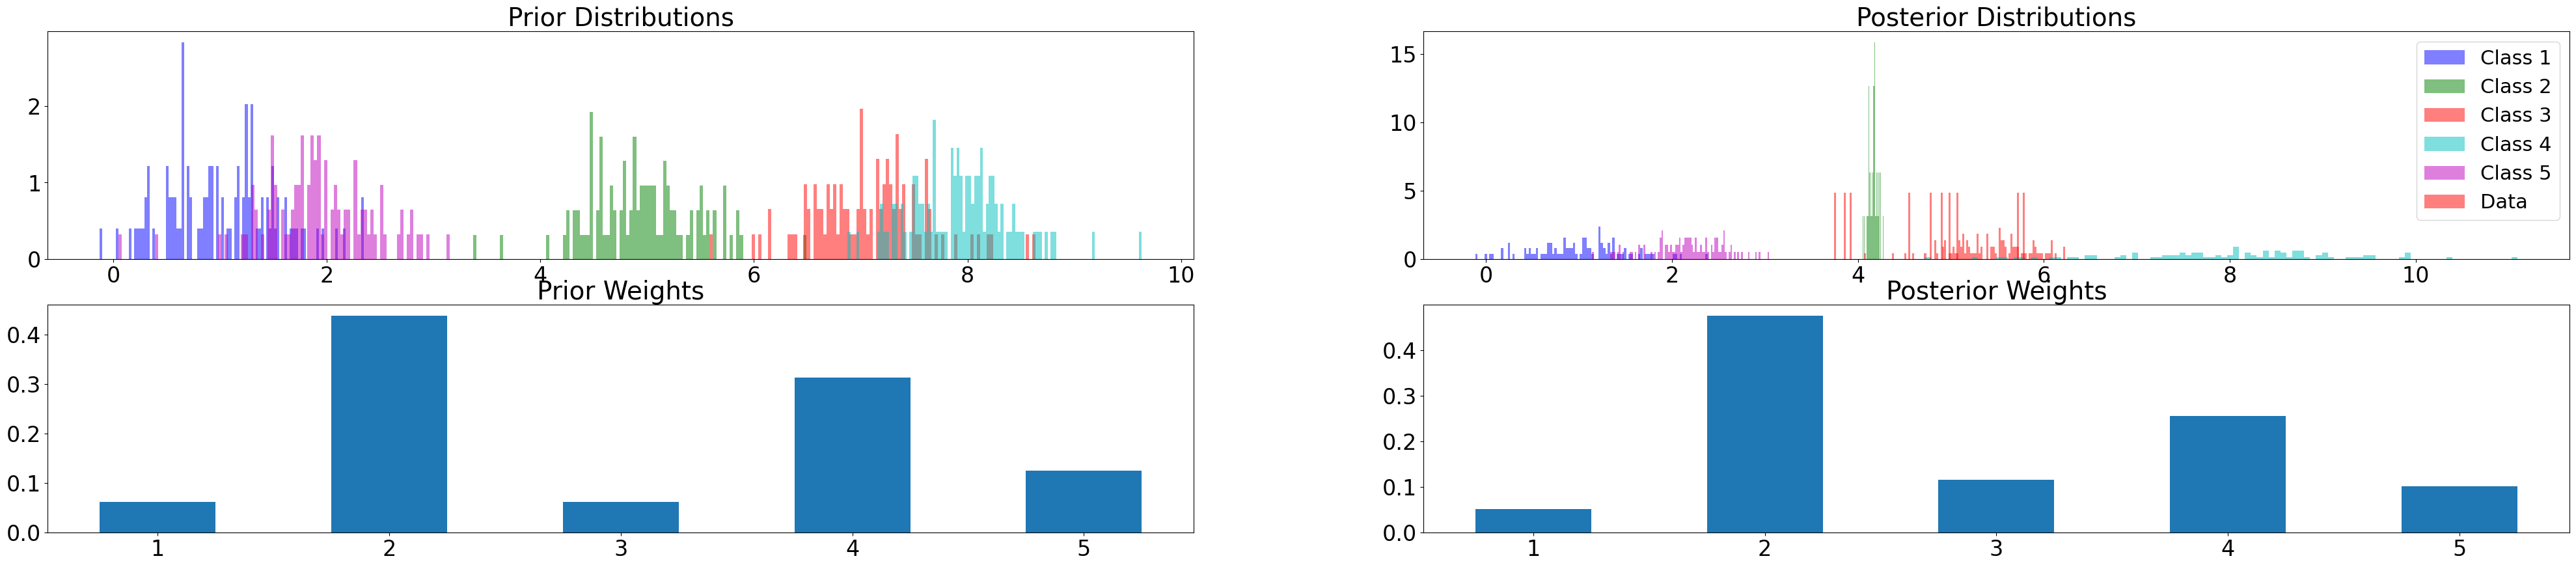

In [ ]:
num_samples = 100
post_mean_samples = samples_normal_gamms(curr_params,num_samples)
prior_mean_samples = samples_normal_gamms(prior_params,num_samples)
print(post_mean_samples)

# plt.hist(post_mean_samples[0,:,0], bins=100, density = "on",alpha = 0.5,fc ="green" )
# plt.hist(post_mean_samples[1,:,0], bins=100, density = "on",alpha = 0.5,fc ="blue")
# plt.show()
fig, axs = plt.subplots(2, 2, figsize = (50,10))
colors = ['b','g','r','c','m','y']
for i in range(curr_params.alphas.shape[0]):

  axs[0, 0].hist(prior_mean_samples[i,:,0], bins=100, density = "on",alpha = 0.5,fc =colors[i], label="Class %d"%(i+1) )
  axs[0, 1].hist(post_mean_samples[i,:,0], bins=100, density = "on",alpha = 0.5,fc =colors[i] , label="Class %d"%(i+1))



axs[0, 0].set_title('Prior Distributions', fontsize=28)
axs[0, 0].tick_params(axis='both', labelsize=24)

axs[0, 1].hist(measurements, bins=100, density = "on",alpha = 0.5,fc ="red", label="Data" )
axs[0, 1].set_title('Posterior Distributions', fontsize=28)
axs[0, 1].legend(fontsize = 22)
axs[0, 1].tick_params(axis='both', labelsize=24)
axs[1, 0].bar([1,2,3,4,5], height = prior_params.a/np.sum(prior_params.a), width = 0.5)
axs[1, 0].set_title('Prior Weights', fontsize=28)
axs[1, 0].tick_params(axis='both', labelsize=24)
axs[1, 1].bar([1,2,3,4,5], height = curr_params.a/np.sum(curr_params.a), width = 0.5)
axs[1, 1].set_title('Posterior Weights', fontsize=28)
axs[1, 1].tick_params(axis='both', labelsize=24)

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()


